In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import glob

### Reading the spectra file which is in ascii format with first column containing wavelength data and second column containing relative flux or spectra.

In [2]:
data = ascii.read('../comb05.spec')
lamda_galaxy = data['col1']
spectra_galaxy = data['col2']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
print(lamda_galaxy_range)

[5561.54, 8116.54]


### Normalizing the input spectra to avoid numerical problems as suggested by the package. It says--   'Make sure the spectra are rescaled to be not too many order of magnitude different from unity, to avoid  over or underflow problems in the calculation.' 
### Both the input spectra and templates have to be logarithmically rebinned inorder to use as input for the main function of the package. As the 'log_rebin' function of the package keep the flux fixed, it does not matter whether the normalization has been done before or after rebinning.

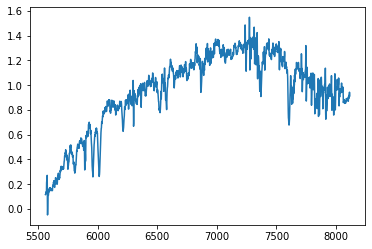

In [3]:
spectra_galaxy = spectra_galaxy / np.median(spectra_galaxy)
plt.plot(lamda_galaxy, spectra_galaxy)

### We need to provide a velocity scale about which the velocity dispersion will be calculated. It has to be the same for both the galaxy and the template spectra. This velocity scale can be calculated from wavelength of the spectra or from priliminary estimated redshift of galaxy. According to the section 2.3 of the paper [Cappellari (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C) in the limit of small V,   
$$V \equiv c \Delta ln \lambda = cln(1+z)$$


In [4]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 67.373149497962


### Here we logarithmically rebinning the input spectra inorder to use as input for the main function of the package. 

In [5]:
spectra_galaxy_new, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy, 
                                                         velscale=velocity_scale)

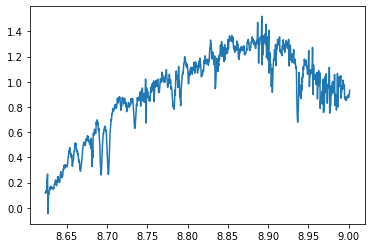

In [6]:
plt.plot(log_lamda_galaxy, spectra_galaxy_new)

### Here we are using only one template spectra to compare or fit with the input spectra. The wavelength range of input spectra and template are quiet different. The difference is due to the cosmological redsfift of the galaxy spectra. The redshift of template spectra is zero. So the wavelength of template spectra is $\lambda_{rest}$ and then the corresponding wavelength for the galaxy spectra is $\lambda_{galaxy}= \lambda_{rest}(1+z)$

In [7]:
template_data = ascii.read('../MILES_library_v9.1_ASCII/s0010') # a random tamplate from library
lamda_template = template_data['col1']                       # wavelength in angstrom
spectra_template = template_data['col2']                     # spectra
lamda_template_range = [np.min(template_data['col1']), np.max(template_data['col1'])]
print(lamda_template_range)

[3500.0, 7429.4]


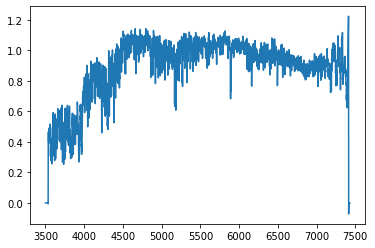

In [8]:
plt.plot(lamda_template, spectra_template)

### Here we logarithmically rebinning the tamplate spectra inorder to use as input for the main function of the package.

In [9]:
spectra_template_new, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

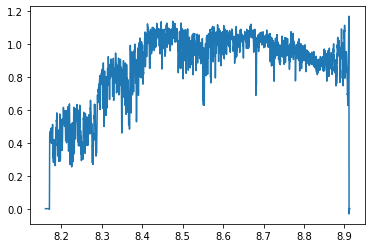

In [10]:
plt.plot(log_lamda_template, spectra_template_new)

### Noise is a required input parameter for the main function. If no reliable noise is available then we have to assume constant noise per pixel. The noise array should have the same size as input spectra. For our input spectra we have variance for each relative flux. As we have normalized our spectra with median then we have to take care of errors accordingly. If a function, $f = \frac{A}{B}$, where A and B are two random variable and $\sigma_A$ and $\sigma_B$ are their errors respectively then from the propagation of error we get the errors associated with the function as $\sigma_f = |f| \sqrt{(\frac{\sigma_A}{A})^2 + (\frac{\sigma_B}{B})^2 - 2 \frac{\sigma_AB}{AB} }$. Here A is the relative flux of the input spectra and B is the median of the spectra. And their covariance or $\sigma_{AB}^2$ is zero.

In [11]:
## Currently not using this
variance_galaxy_spectra = data['col3'] 
error_galaxy_spectra = np.sqrt(variance_galaxy_spectra)             #sigma of A

median_galaxy_spectra = np.median(data['col2'])                     # B value
median_index = list(data['col2']).index(median_galaxy_spectra)      
median_error = error_galaxy_spectra[median_index]                   # sigma of B

F = data['col2'] / np.median(data['col2'])                          # f
noise_1 = np.abs(F)* np.sqrt((error_galaxy_spectra/data['col2'])**2 +     
                             (median_error/median_galaxy_spectra)**2) # sigma of f

#plt.plot(lamda_galaxy, F, 'k')
#plt.plot(lamda_galaxy, noise_1, 'g')

In [12]:
## For now we are using constant noise
noise = np.full_like(spectra_galaxy_new, 0.0166)

### Just to check we did things correctly in the noise section 

In [13]:
## Currently not using this
index= list(data['col2']).index(np.median(data['col2']))
#print(index)                                                  # printing index of the median 
#print(np.median(data['col2']))                                # printing the median 
#print(data['col2'][index])                                    # agian printing median accessing by it's index
#plt.plot(lamda_galaxy, data['col2'], 'k')                     # spectra before normalizing
#plt.plot(lamda_galaxy, np.sqrt(data['col3']), 'g')            # error before 

###  We need to provide an initial estimate for the LOSVD (line of sight velocity distribution) parameters. If these parameters are not held fixed then need to provide an estimate only for velocity and velocity dispersion which are first and second element in the array 'start'. According to the package, unless a good initial guess is available, it is recommended to set the starting sigma >= 3*velscale in km/s (i.e. 3 pixels).  Calculated velocity scale from input spectra is 67.37 km/s. So the initial guess for velocity dispersion is more than three times of velocity scale.

In [14]:
z = 0.516               # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]     

### The five required inputs for the main function which is 'ppxf' are logarithmically rebinned input spectra, and templates, noise, velocity scale and start. There are lots of other optional parameters enabling various features. The 'moments' parameter can be used to define how many statistical moments we are interested in fitting. 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    125565       116    -0.000    -0.004
chi2/DOF: 31.53
method = capfit; Jac calls: 6; Func calls: 34; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  0 / 1
Templates weights:
   -0.0481


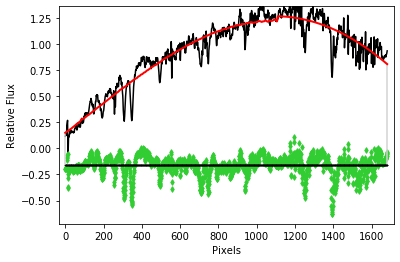

In [15]:
pp = ppxf(spectra_template_new, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True)

### Using 'lam' parameter we can have the best fit plot in wavelengths rather than pixel value.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    125565       116    -0.000    -0.004
chi2/DOF: 31.53
method = capfit; Jac calls: 6; Func calls: 34; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  0 / 1
Templates weights:
   -0.0481


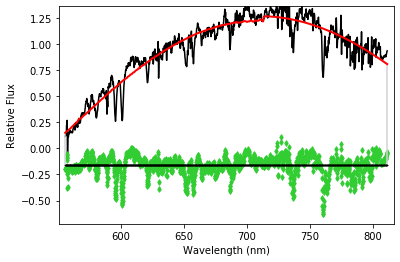

In [16]:
pp = ppxf(spectra_template_new, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, lam=np.exp(log_lamda_galaxy))

### We want to calculate the sigma of the Gaussian distribution with which the template spectras would be convolved. We mean with the Gaussian distribution $K$ the templates $T$ become  $\tilde{T}(x) = T(x) * K (x, \lambda) $ where $x= ln\lambda$. And also line spread function (LSF) of the galaxy and templates are related as $LSF_{gal}(x, \lambda) = LSF_{tem}(x, \lambda) * K(x, \lambda) $. After that we will use these convolved templates $\tilde{T}$  further to get  $G_{mod}(x) = \tilde{T}(x) * L(v)$ where $G_{mod}$ is the model of galaxy spectra and $L(v)$ is the LOSVD.

### Full width at half maximum (FWHM) is related to sigma or dispersion if we assume a Gaussian distribution. The relation is $ FWHM = 2\sqrt(2 ln2) \sigma \approx 2.355 \sigma$. If we want to find out FWHM of every pixel then $FWHM \approx 2.355 \sigma \Delta \lambda$ where $\Delta \lambda$ is the size of every pixel. Using this relation here we calculate FWHM of the galaxy spectrum at every pixel.

In [17]:
variance_galaxy_spectra = data['col3'] 
sigma_galaxy_spectra = np.sqrt(variance_galaxy_spectra)          #sigma of each pixel in spectra
pixel_size_gal_spec = (frac_lamda - 1) * lamda_galaxy                     # pixel size in Angstrom
fwhm_galaxy_spectra = 2.355 * sigma_galaxy_spectra * pixel_size_gal_spec  # FWHM of every pixel in Angstrom

### Vazdekis+10 spectra (the templates we are using here) have a constant resolution FWHM of 2.51 A. And a constant pixel size of 0.9A.  

In [18]:
fwhm_template_spectra = 2.51        # in Angstrom
pixel_size_tem_spec = 0.9           # in Angstrom

### In order to get sigma $\sigma_{K}(\lambda)$ of the Gaussian distribution $K$ for every pixel first we need to have FWHM of the galaxy and template spectra at the same wavelength or pixel location. But we know that these two wavelength sets are different as their resolutions are different and also the overall range. As the resolution of the templates are higher or pixel size are smaller than galaxy spcetrum, we can interpolate the FWHM of the galaxy spectrum at the locations of the every pixel of the template spectrum. According to one example of the package "outside the range of the galaxy spectrum the resolution will be extrapolated, but this is irrelevant as those pixels cannot be used in the fit anyway."

In [19]:
fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
sigma_diff = (fwhm_diff / 2.355)/pixel_size_tem_spec
#sigma_diff = np.sqrt(variance_galaxy_spectra - (fwhm_template_spectra / 2.355 / pixel_size_tem_spec)**2)

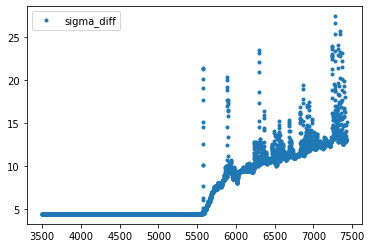

In [20]:
## Here is the plot of the sigma_diff at the pixel location of the templates

plt.plot(lamda_template, sigma_diff,'.', label='sigma_diff')
plt.legend()

### Loading addresses of all the templates spectra in the library

In [21]:
vazdekis_library = glob.glob('../MILES_library_v9.1_ASCII/*')

### We have already extracted the wavelength range and rebinned logarithmically one of the template spectra to the same velocity scale of the galaxy spectrum. Using this information we can determine the size needed for the array which will contain the template spectra.

In [22]:
templates = np.empty((spectra_template_new.size, len(vazdekis_library)))

### Here we convolve the whole Vazdekis library of spectral templates with the quadratic difference ('sigma_diff') between the galaxy spectrum and the Vazdekis instrumental resolution. Logarithmically rebin and store each template as a column in the array TEMPLATES.

In [29]:
for j, file_name in enumerate(vazdekis_library):
     
    template_data = ascii.read(file_name)
    template_spectra = template_data['col2']

    # perform convolution with variable sigma_diff    
    convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

    template_spectra_new = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
    templates[:, j] = template_spectra_new/np.median(template_spectra_new) # Normalizes templates
     

### The galaxy and the template spectra do not have the same starting wavelength. For this reason an extra velocity shift 'dv' has to be applied to the template to fit the galaxy spectrum. We remove this artificial shift by using the keyword 'vsyst' in the call to PPXF below, so that all velocities are measured with respect to 'dv'. This assume the redshift is negligible.

In [30]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

### Here we call the 'ppxf' function with the logarithmically rebinned templtae spectra libarary,  galaxy spectra, constant noise and other required parameters.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124552       155     0.134    -0.057
chi2/DOF: 9.268
method = capfit; Jac calls: 6; Func calls: 34; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 985


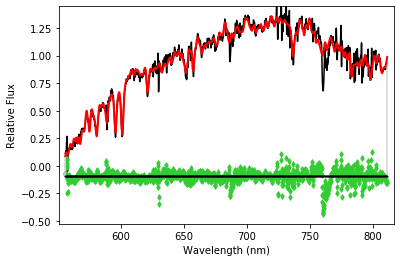

In [31]:
pp = ppxf(templates, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, lam=np.exp(log_lamda_galaxy))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124546       131     0.109    -0.067
chi2/DOF: 8.604
method = capfit; Jac calls: 8; Func calls: 44; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 985


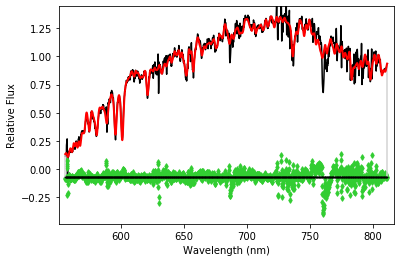

In [34]:
pp = ppxf(templates, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, degree=10, lam=np.exp(log_lamda_galaxy))